 # 뉴욕시 택시 요금 예측
 > 뉴욕시의 노란 택시는 뉴욕의 상징과도 같다. 수만 명의 직장인이 번화한 대도시 주변을 오가는 교통 수단으로 택시를 이용한다. 하지만 최근 뉴욕 택시 업계는 우버를 비롯한 택시 호출 앱의 거센 위협을 받았다. 노란 택시는 우버의 도전에 대항하기 위해 운영 방식을 현대화하고 우버와 동등한 사용자 경험을 제공하려 노력했다. 2018년 8월 뉴욕시 택시 리부진 협회는 노란 택시를 손쉽게 예약할 수 있는 새로운 앱을 출시했다. 이 앱은 택시를 호출하기 전에 예상 요금을 예측해 알려준다.
 <br>
 * 뉴욕시 택시 요금 데이터셋 (./data/taxi.cav)<br>
 노란 택시가 2009년부터 2015년까지 5,500만 회 운행한 기록이며 승객이 타고 내린 위치, 승객 수 , 승차 시간 등을 포함한다.

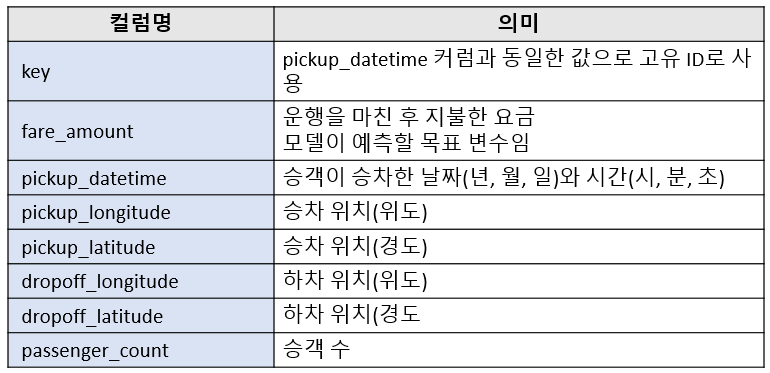

## 탐색적 데이터 분석

In [2]:
# 판다스 임포트 

import pandas as pd

* 5,500만 행이나 되는 원본 데이터셋을 가져오기는 어렵다. 평범한 PC로는 데이터셋 전체를 메모리에 올릴 수 없다. 대신 맨 처음 50만 행만 가져온다. 

In [3]:
# 데이터셋 로드하여 df에 대입, nrows=500000, index_col=0

df = pd.read_csv('./data/taxi_raw.csv', nrows=500000, index_col=0)


In [4]:
# df의 처음 다섯 행을 확인

df.head(1)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1


In [5]:
# df의 마지막 다섯 행을 확인

df.tail(1)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
499999,2010-04-12 23:46:58.0000002,4.9,2010-04-12 23:46:58 UTC,-73.986743,40.722187,-73.982768,40.71333,1


In [6]:
# df의 샘플 5개 행을 확인

df.sample(1)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
409263,2009-04-27 14:45:33.0000001,6.9,2009-04-27 14:45:33 UTC,-73.962935,40.772559,-73.976173,40.756224,1


In [7]:
# df의 행, 열 수 확인

df.shape

(500000, 8)

In [8]:
# df의 요약 정보 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                500000 non-null  object 
 1   fare_amount        500000 non-null  float64
 2   pickup_datetime    500000 non-null  object 
 3   pickup_longitude   500000 non-null  float64
 4   pickup_latitude    500000 non-null  float64
 5   dropoff_longitude  499995 non-null  float64
 6   dropoff_latitude   499995 non-null  float64
 7   passenger_count    500000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 34.3+ MB


In [9]:
# df의 모든 컬럼의 데이터 타입 확인

df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

* 컬럼 pickup_datetime이 문자열(object)타입이다. 이 컬럼의 데이터 타입을 날짜시간 데이터 타입(datetime64)로 변경한다.

In [9]:
# 'pickup_datetime'의 데이터 타입을 datetime64로 변경한다.

df['pickup_datetime']=df['pickup_datetime'].astype('datetime64')

In [10]:
# df의 모든 컬럼의 데이터 타입 확인
# 'pickup_datetime'이 datetime64로 바뀌었음을 확인한다.

df.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

### 위치 데이터 시각화
> 요금 예측에서 가장 중요한 정보는 승차 위치와 하차 위치이다. 뉴욕시 택시 요금은 대부분 운행 거리로 결정하기 때문이다.

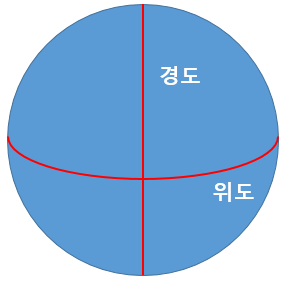

* 승하차의 위치를 뉴욕시 내로 한정한다. 
* 뉴욕시는 대략 경도 -74.05에서 -73.75사이에, 그리고 위도 40.63에서 40.85 사이에 위치한다.

In [11]:
# 뉴욕시의 경도 범위

nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

In [12]:
# 뉴욕시의 위도 범위

nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

In [13]:
# df를 복사하여 df2를 만든다.

df2= df.copy()

* 승차위치가 뉴욕시인 데이터를 필터링한다.

In [14]:
# 'pickup_longitude'가 nyc_min_longitude보다 크고, nyc_max_longitude는 작은 데이터들만 추출하여 df2에 대입한다.

df2 = df2.loc[(df2['pickup_longitude'] > nyc_min_longitude) &(df2['pickup_longitude'] < nyc_max_longitude)]
df2

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12,-73.978775,40.766724,-73.966072,40.758537,1
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34,-74.002932,40.718408,-74.009442,40.710952,1
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20,-73.983885,40.725611,-73.896482,40.700980,1
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32,-73.974617,40.756512,-73.970184,40.764801,6


In [15]:
# 'pickup_latitude'가 nyc_min_latitude보다 크고, nyc_max_latitude는 작은 데이터들만 추출하여 df2에 대입한다.

df2 = df2.loc[(df2['pickup_latitude'] > nyc_min_latitude) &(df2['pickup_latitude'] < nyc_max_latitude)]
df2

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12,-73.978775,40.766724,-73.966072,40.758537,1
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34,-74.002932,40.718408,-74.009442,40.710952,1
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20,-73.983885,40.725611,-73.896482,40.700980,1
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32,-73.974617,40.756512,-73.970184,40.764801,6


* 하차위치가 뉴욕시인 데이터를 필터링한다.

In [16]:
# 'dropoff_longitude'가 nyc_min_longitude보다 크고, nyc_max_longitude는 작은 데이터들만 추출하여 df2에 대입한다.

df2 = df2.loc[(df2['dropoff_longitude'] > nyc_min_longitude) &(df2['dropoff_longitude'] < nyc_max_longitude)]
df2

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12,-73.978775,40.766724,-73.966072,40.758537,1
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34,-74.002932,40.718408,-74.009442,40.710952,1
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20,-73.983885,40.725611,-73.896482,40.700980,1
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32,-73.974617,40.756512,-73.970184,40.764801,6


In [17]:
# 'dropoff_latitude'가 nyc_min_latitude보다 크고, nyc_max_latitude는 작은 데이터들만 추출하여 df2에 대입한다.

df2 = df2.loc[(df2['dropoff_latitude'] > nyc_min_latitude) &(df2['dropoff_latitude'] < nyc_max_latitude)]
df2

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12,-73.978775,40.766724,-73.966072,40.758537,1
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34,-74.002932,40.718408,-74.009442,40.710952,1
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20,-73.983885,40.725611,-73.896482,40.700980,1
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32,-73.974617,40.756512,-73.970184,40.764801,6


In [18]:
# 뉴욕시에서 승하차한 데이타만 필터링 된 df2확인

df2

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12,-73.978775,40.766724,-73.966072,40.758537,1
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34,-74.002932,40.718408,-74.009442,40.710952,1
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20,-73.983885,40.725611,-73.896482,40.700980,1
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32,-73.974617,40.756512,-73.970184,40.764801,6


* 뉴욕시의 핵심 랜드마트도 시각화한다.

In [19]:
# 뉴욕시 핵심 랜트마크 데이터(경도, 위도)

landmarks = {'JFK Airport': (-73.78,40.643),
             'Laguardia Airport': (-73.87, 40.77),
             'Midtown': (-73.98, 40.76),
             'Lower Manhattan': (-74.00, 40.72),
             'Upper Manhattan': (-73.94, 40.82),
             'Brooklyn': (-73.95, 40.66)} 

In [20]:
# 시각화를 위해 matplotlib.pyplot임포트

import matplotlib.pyplot as plt

In [21]:
# 승하차 위치를 점 그래프로 시각화하는 함수 정의

def plot_lat_long(df, landmarks, points='Pickup'):
    plt.figure(figsize=(12,12))
    if points == 'Pickup':
        plt.plot(list(df['pickup_longitude']), list(df['pickup_latitude']), '.', markersize=1)
    else:
        plt.plot(list(df['dropoff_longitude']), list(df['dropoff_latitude']), '.', markersize=1)
        
    for landmark in landmarks:
        plt.plot(landmarks[landmark][0], landmarks[landmark][1], '*', markersize=15, alpha=1, color='r')
        plt.annotate(landmark, (landmarks[landmark][0]+0.005, landmarks[landmark][1]+0.005), color='r', backgroundcolor='w')
    
    plt.title(points + ' Locations in NYC Illustrated')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()

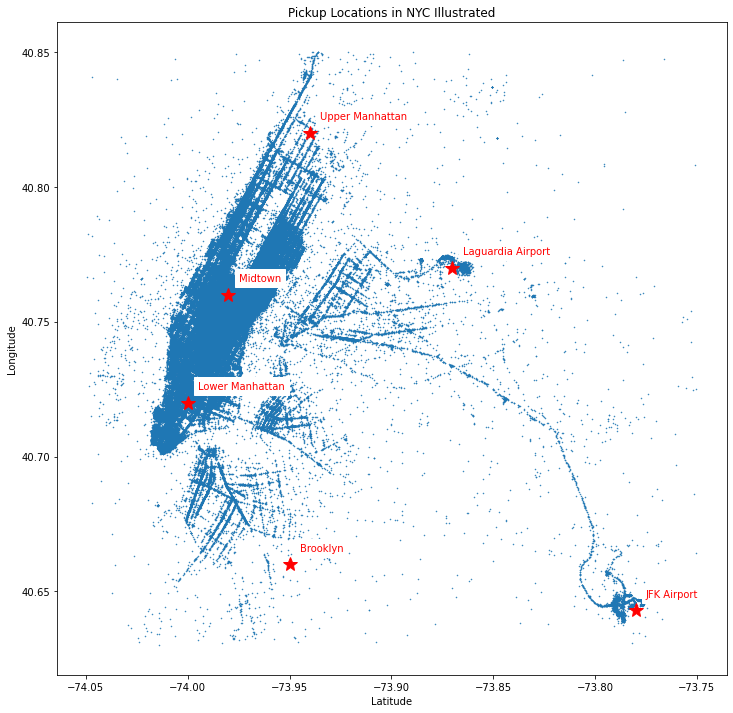

In [22]:
# plot_lat_long()함수를 호출하여 승차위치를 점그래프로 시각화한다.

plot_lat_long(df2, landmarks, 'Pickup')

* 맨하탄 섬에서는 Midtown에서 가장 많이 승차한다. 그다음으로 Lower Manhattan에서 많이 승차함을 알 수 있다. 그에 비해 Upper Manhattan에서는 탑승 횟수가 적은 편이다. Upper Manhattan은 대체로 주거구역인 반면, Midtown과 LowerManhattan에는 사무실과 관광지가 몰려 있기 때문이다.
* 맨하탄 섬 바깥에서 승차하는 경우는 드물다는 것을 알 수 있다. 단, Laguardia Airport와 JFK Airport는 예외적으로 승차하는 경우가 많다.

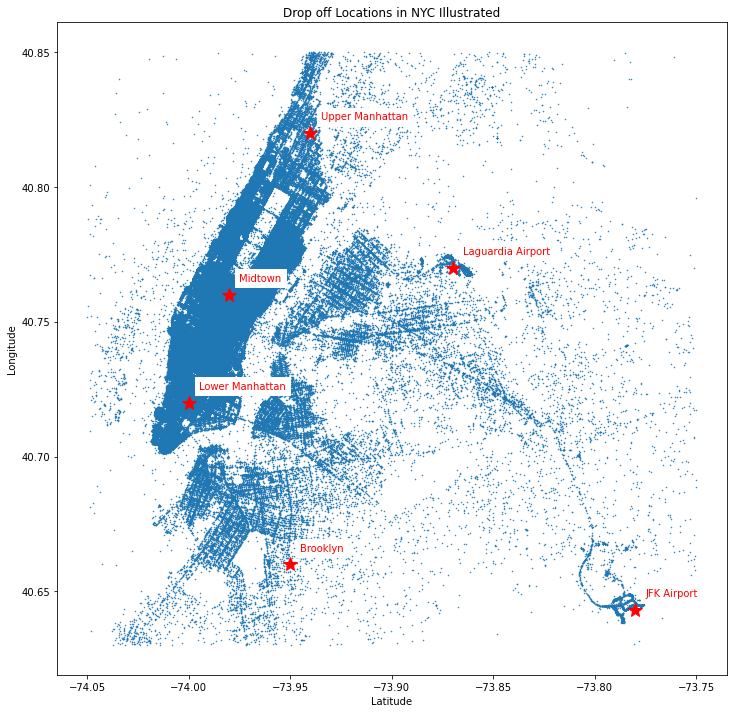

In [23]:
# plot_lat_long()함수를 호출하여 하차위치를 점그래프로 시각화한다.

plot_lat_long(df2, landmarks, 'Drop off')

* 승차 그래프와 비교하면, Upper Manhattan과 Brooklyn 같은 주거지역에 하차가 더 많다는 것을 알 수 있다.

### 요일 및 시간별 승차 통계
* 요일과 시간에 따른 승차 수를 집계해 본다.
* pickup_datetime 컬럼 하나에 승차 일자 및 시간 정보가 datetime 형식으로 저장되어 있다. 이 컬럼을 연, 월, 일, 요일, 시각 요소로 나누어 각각 다른 컬럼에 저장한다.

In [24]:
# df의 첫번째 행을 확인 한다.

df.head(1)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.84161,40.712278,1


In [25]:
# df의 모든 컬럼의 데이터 타입을 확인한다.

df.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [26]:
# df의 'pickup_datetime' 컬럼에서 년도를 분리하여 'year' 컬럼에 대입한다.

df['year']= df['pickup_datetime'].dt.year

In [27]:
# df의 'pickup_datetime' 컬럼에서 달을 분리하여 'month' 컬럼에 대입한다.

df['month']= df['pickup_datetime'].dt.month

In [28]:
# df의 'pickup_datetime' 컬럼에서 일을 분리하여 'day' 컬럼에 대입한다.

df['day']= df['pickup_datetime'].dt.day

In [29]:
# df의 'pickup_datetime' 컬럼에서 요일을 분리하여 'day_of_week' 컬럼에 대입한다.

df['day_of_week']= df['pickup_datetime'].dt.day_of_week

In [30]:
# df의 'pickup_datetime' 컬럼에서 시간을 분리하여 'hour' 컬럼에 대입한다.

df['hour']= df['pickup_datetime'].dt.hour

In [50]:
# df를 확인한다.

df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12,-73.978775,40.766724,-73.966072,40.758537,1,2015,5,7,3,18
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34,-74.002932,40.718408,-74.009442,40.710952,1,2010,9,13,0,12
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20,-73.983885,40.725611,-73.896482,40.700980,1,2014,8,25,0,0
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32,-73.974617,40.756512,-73.970184,40.764801,6,2015,1,12,0,12


* 요일별 승차분포를 히스토그램으로 시각화해본다.

<AxesSubplot:ylabel='Frequency'>

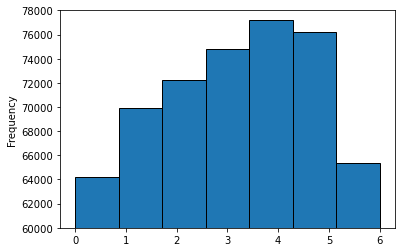

In [55]:
# 'day_of_week'컬럼을 선택하여 히스토그램을 그려본다.(ylim=(60000, 78000), ec='black', bins=7)

df['day_of_week'].plot.hist(bins=7, ec='black', ylim=(60000,78000))

* 요일별로 승차 수가 확연히 다른 것을 알 수 있다. 월요일부터 금요일까지는 꾸준히 증가하며 금요일에 정점을 찍는다. 또한 토요일에 약간 감소한 뒤 일요일에 급감한다.

* 시간별 승차분포를 히스토그램으로 시각화해본다.

<AxesSubplot:ylabel='Frequency'>

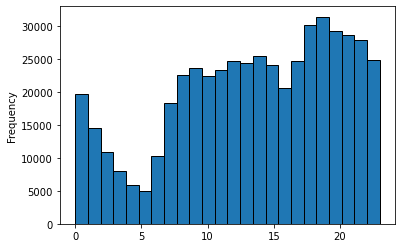

In [56]:
# 'hour'컬럼을 선택하여 히스토그램을 그려본다.(ec='black', bins=24)

df['hour'].plot.hist(bins=24, ec='black')

* 아침 출근 시간보다 저녁 퇴근 시간에 승차 수가 더 많다. 낮 시간에는 분포가 꽤 일정하다. 이후 오후 6시부터 증가하고 오후 7시에 정점을 찍은 다음, 밤 11시부터 급감한다.

## 데이터 전처리

### 결측치 및 이상치 처리

* 데이터 셋에 결측치가 있는지 확인해본다.

In [57]:
# df의 결측치 수 확인

df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
year                 0
month                0
day                  0
day_of_week          0
hour                 0
dtype: int64

* 전체 50만 행 중에 결측치를 가진 행은 5개이다. 제거해도 문제 없을 것으로 생각되므로 제거한다.

In [58]:
# df의 결측치 제거하고 결과를 다시 df에 대입한다.

df = df.dropna()
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12,-73.978775,40.766724,-73.966072,40.758537,1,2015,5,7,3,18
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34,-74.002932,40.718408,-74.009442,40.710952,1,2010,9,13,0,12
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20,-73.983885,40.725611,-73.896482,40.700980,1,2014,8,25,0,0
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32,-73.974617,40.756512,-73.970184,40.764801,6,2015,1,12,0,12


* 데이터 셋에 이상치(outlier)가 있는지 확인해 본다.

In [59]:
# df의 통계정보를 요약해본다.

df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358182,-72.520091,39.920350,-72.522435,39.916526,1.683445,2011.739129,6.268617,15.684239,3.042020,13.510843
std,9.916069,11.856446,8.073318,11.797362,7.391002,1.307391,1.860897,3.437798,8.681092,1.949243,6.511596
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992047,40.734916,-73.991382,40.734057,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000


* fare_amount의 최소값(min)이 -44.9달러이다. 요금이 음수가 될 수는 없다. 반면 가장 비싼 요금은 500달러이다. 바가지 요금일 수도 있고 단순한 오류일 수도 있다.
* 요금의 분포를 히스토그램으로 시각화해본다.

<AxesSubplot:ylabel='Frequency'>

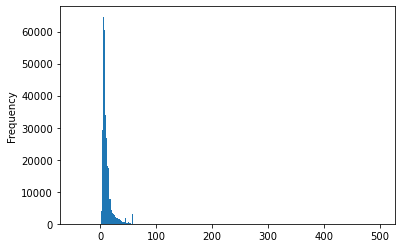

In [60]:
# 'fare_amount' 컬럼을 히스토그램으로 시각화해본다.(bins=500)

df['fare_amount'].plot.hist(bins=500)

* 분포상 이상치가 많지 않으므로 제거해도 문제가 없어 보인다. 50달러 주변이 약간 튀어나온 것을 볼 수 있는데, 어쩌면 정액 요금때문일 수 있다. 간혹 공항을 오고가는 택시 요금을 정액으로 규정한 도시들이 있다. 예를 들면, JFK 공항을 오고가는 택시는 52달라로 정해진 금액에 통행료를 추가한 요금을 받는다.
* 0달러보다 적거나 100달러보다 큰 요금을 가진 행을 제거한다.

In [62]:
# 'fare_amount' 컬럼의 데이터가 0이상이고 100이하인 데이터만 필터링한다.
# 필터링 결과를 df에 대입한다.

df = df.loc[(df['fare_amount']>= 0 ) & (df['fare_amount'] <= 100)]
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12,-73.978775,40.766724,-73.966072,40.758537,1,2015,5,7,3,18
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34,-74.002932,40.718408,-74.009442,40.710952,1,2010,9,13,0,12
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20,-73.983885,40.725611,-73.896482,40.700980,1,2014,8,25,0,0
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32,-73.974617,40.756512,-73.970184,40.764801,6,2015,1,12,0,12


* 통계요약 결과를 보면 승객수가 0인 데이터가 있다. 
* passenger_count 컬럼의 이상치를 확인하기 위해 히스토그램을 이용하여 분포를 시각화해본다.

<AxesSubplot:ylabel='Frequency'>

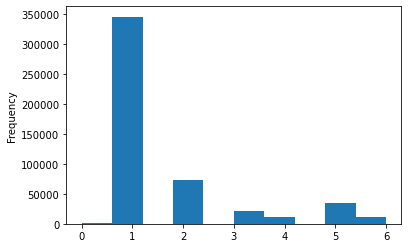

In [63]:
# 'passenger_count' 컬럼을 선택하여 히스토그램을 그려본다.

df['passenger_count'].plot.hist()

* 극소수지만 승객 수가 0명인 데이터가 있다. 이 행을 버리지 말고 대신 데이터의 최빈값(mode)으로 대체한다.

In [66]:
# df의 'passenger_count' 컬럼의 최빈값(mpde)을 확인한다.

df['passenger_count'].mode()

0    1
dtype: int64

In [68]:
# 'passenger_count'컬럼의 데이터가 0인 행을 선택하고 그 행들의 'passenger_count' 컬럼에 passenger_count' 컬럼의 최빈값(mpde)을 대입한다.

df.loc[df['passenger_count'] == 0, 'passenger_count'] = df['passenger_count'].mode()

* 승하차 위치에 이상치가 있는지 확인해본다.
* 전체 위도와 경도 데이터를 scatter플롯으로 시각화해본다.

In [71]:
(df['passenger_count']==0).value_counts()

False    499760
Name: passenger_count, dtype: int64

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

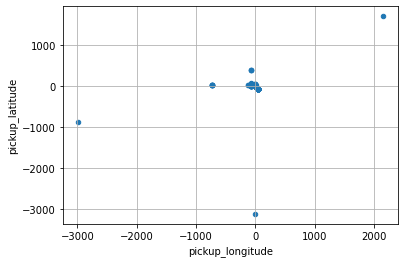

In [73]:
# 'pickup_longitude'를 x축으로 'pickup_latitude'를 y축으로 하여 산점도를 시각화해본다.

df.plot.scatter('pickup_longitude', 'pickup_latitude', grid=True)

* 산점도의 가장자리에 있는 점들은 모두 이상치이다. 가장 큰 위도 값은 1000을 넘고, 가장 작은 값은 -3000을 넘는다. 하지만 지리 좌표 체계에는 이렇게 큰 위도 값들은 없다. 따라서 이 값들을 제거한다.
* 즉, 승하차 위도, 경도 값을 뉴욕시 범위내로 한정한다.

In [74]:
# 승하차 경도를 뉴욕시 범위로 한정한다. 

for long in ['pickup_longitude', 'dropoff_longitude']:
    df = df.loc[(df[long] > nyc_min_longitude) & (df[long] < nyc_max_longitude)]    

In [75]:
# 승하차 위도를 뉴욕시 범위로 한정한다.

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df = df.loc[(df[lat] > nyc_min_latitude) & (df[lat] < nyc_max_latitude)]

In [76]:
# df확인 

df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,1,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,3,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12,-73.978775,40.766724,-73.966072,40.758537,1.0,2015,5,7,3,18
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34,-74.002932,40.718408,-74.009442,40.710952,1.0,2010,9,13,0,12
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20,-73.983885,40.725611,-73.896482,40.700980,1.0,2014,8,25,0,0
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32,-73.974617,40.756512,-73.970184,40.764801,6.0,2015,1,12,0,12


## 특징 공학(Feature Engineering)
> 특징 공학은 당면 문제의 도메인 지식을 활용해 머신러닝 알고리즘에 사용할 새로운 특징 변수(컬럼)을 만드는 과정이다.

* 승차 날짜와 승차 위치 변수(컬럼)를 바탕으로 새로운 특징 변수(컬럼)을 만든다.

### 시간관련 변수

In [77]:
# df의 모든 컬럼의 데이터 타입을 확인한다.

df.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count             float64
year                          int64
month                         int64
day                           int64
day_of_week                   int64
hour                          int64
dtype: object

* 신경망은 숫자형 변수만 처리할 수 있으며 datetime, 문자열은 사용할 수 없다.
* pickup_datetime 컬럼을 year, month, day, day_of_week, hour 컬럼으로 나눈다.
* pickup_datetime은 제거한다.

In [81]:
# df의 'pickup_datetiem' 컬럼을 제거한다.
# 결과를 df에 대입한다.

df= df.drop(columns=['pickup_datetime'], axis=1)
df

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,0,17
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,1,16
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,3,0
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,-73.978775,40.766724,-73.966072,40.758537,1.0,2015,5,7,3,18
499996,2010-09-13 12:11:34.0000004,13.7,-74.002932,40.718408,-74.009442,40.710952,1.0,2010,9,13,0,12
499997,2014-08-25 00:22:20.0000001,25.0,-73.983885,40.725611,-73.896482,40.700980,1.0,2014,8,25,0,0
499998,2015-01-12 12:17:32.0000001,6.5,-73.974617,40.756512,-73.970184,40.764801,6.0,2015,1,12,0,12


### 위치관련 변수

* 데이터 셋에는 승차 및 하차 위치 정보가 있지만 택시 요금에서 가장 중요한 요소인 운행 거리 정보가 없다. 따라서 승차 위치와 하차 위치 정보를 사용해 거리를 계산하고 새로운 특징 변수를 추가한다.
* 운행 거리는 유클리드 거리로 계산한다.

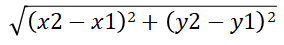

In [83]:
# (dropoff_longitude, dropoff_latitue)와 (pickup_longitude, pickup_lattitude)사이의 거리를 유클리드 공식으로 계산한다.
# 결과를 df['distance']에 대입한다.

df['distance'] = ((df['dropoff_longitude']-df['pickup_longitude'])**2 + (df['dropoff_latitude']-df['pickup_latitude'])**2)**0.5

In [84]:
# df확인

df

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,0,17,0.009436
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,1,16,0.079696
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,3,0,0.013674
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,5,4,0.025340
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,1,7,0.019470
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,-73.978775,40.766724,-73.966072,40.758537,1.0,2015,5,7,3,18,0.015112
499996,2010-09-13 12:11:34.0000004,13.7,-74.002932,40.718408,-74.009442,40.710952,1.0,2010,9,13,0,12,0.009898
499997,2014-08-25 00:22:20.0000001,25.0,-73.983885,40.725611,-73.896482,40.700980,1.0,2014,8,25,0,0,0.090807
499998,2015-01-12 12:17:32.0000001,6.5,-73.974617,40.756512,-73.970184,40.764801,6.0,2015,1,12,0,12,0.009400


* 운행요금과 거리사이의 관계를 산점도 그래프로 시각화해본다.

<AxesSubplot:xlabel='fare_amount', ylabel='distance'>

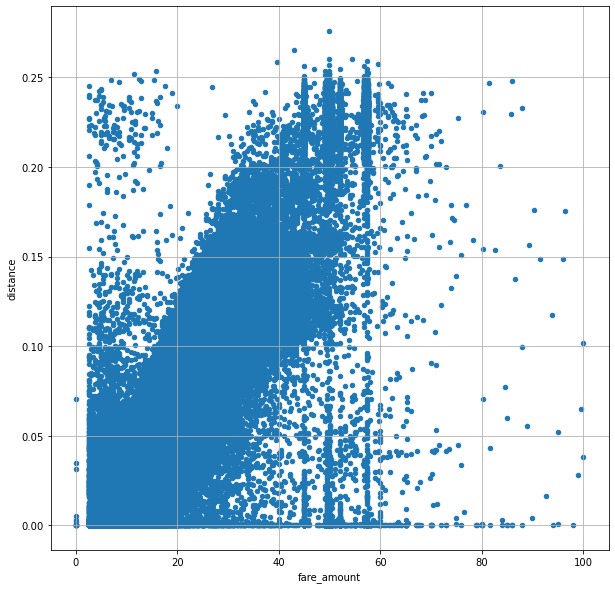

In [85]:
# 'fare_amount'와 'distance'사이의 산점도그래프를 그린다.

df.plot.scatter('fare_amount', 'distance', figsize=(10,10), grid=True)

* 거리와 요금사이에는 비례관계가 있음을 알 수 있다. 
* 하지만 운행 거리와 관계없이 요금이 나온 경우도 있다. 그래프 가운데 수직선이 세 개 있으며, 이 40달러에서 60달러 사이의 점들은 운행 거리가 요금에 영향을 주지 않았다.
* 앞에서 공항 근처에서 승차한 기록들이 있었고 공항을 오가는 택시는 52달러로 고정된 금액에 통행료를 더한 요금을 받는다. 이 정액 요금이 수직선이 생긴 이유일 것이다. 
* 따라서 뉴욕시 주요 공항과 승차 및 하차 위치 사이의 거리를 새로운 특징 변수로 추가할 필요가 있다. 
* 신경망은 이 특징 변수를 사용해 공항을 오고가는 정액 요금을 학슬할 수 있다.

In [86]:
# 주요 공항의 경도(longitude)와 위도(latitude)

airports = {'JFK_Airport': (-73.78,40.643),
            'Laguardia_Airport': (-73.87, 40.77),
            'Newark_Airport' : (-74.18, 40.69)}

In [87]:
# 경도와 위도를 사용해 거리를 계산하는 함수(euc_distance)를 정의

def euc_distance(lat1, long1, lat2, long2):
    return ((lat1-lat2)**2 + (long1-long2)**2)**0.5

* 승객의 승차위치부터 공항까지의 거리, 승객의 하차위치부터 공항까지의 거리를 계산한다.
* 위에 정의한 euc_distance()함수를 이용하여 세 공항과 승하차 위치사이의 거리를 계산한다.

In [88]:
# for문을 이용하여 airports 딕셔너리에 있는 세공항과 승하차 위치사이의 거리를 계산한다.
# 'pickup_dist_' + airport = euc_distance()호출: ('pickup_latitude', airports[airport][1])과 ('pickup_longitude', airports[airport][0]) 사이의 거리
# 'dropoff_dist_' + airport = euc_distance()호출: ('dropoff_latitude', airports[airport][1])과 ('dropoff_longitude', airports[airport][0]) 사이의 거리

for airport in airports:
    df['pickup_dist_' + airport] = euc_distance(df['pickup_latitude'], df['pickup_longitude'], airports[airport][1], airports[airport][0])
    df['dropoff_dist_' + airport] = euc_distance(df['dropoff_latitude'], df['dropoff_longitude'], airports[airport][1], airports[airport][0])


In [89]:
# df확인

df

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport,pickup_dist_Laguardia_Airport,dropoff_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_Newark_Airport
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,0,17,0.009436,0.101340,0.092710,0.055043,0.064326,0.337147,0.339123
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,1,16,0.079696,0.245731,0.242961,0.157402,0.109925,0.165330,0.220812
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,3,0,0.013674,0.234714,0.237050,0.113076,0.122790,0.209742,0.198236
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,5,4,0.025340,0.225895,0.240846,0.122792,0.122149,0.197636,0.200358
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,1,7,0.019470,0.225847,0.225878,0.098115,0.087741,0.225807,0.242228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,-73.978775,40.766724,-73.966072,40.758537,1.0,2015,5,7,3,18,0.015112,0.234135,0.219024,0.108824,0.096753,0.215356,0.224639
499996,2010-09-13 12:11:34.0000004,13.7,-74.002932,40.718408,-74.009442,40.710952,1.0,2010,9,13,0,12,0.009898,0.235340,0.239293,0.142593,0.151429,0.179332,0.171840
499997,2014-08-25 00:22:20.0000001,25.0,-73.983885,40.725611,-73.896482,40.700980,1.0,2014,8,25,0,0,0.090807,0.219986,0.130114,0.122230,0.073926,0.199322,0.283731
499998,2015-01-12 12:17:32.0000001,6.5,-73.974617,40.756512,-73.970184,40.764801,6.0,2015,1,12,0,12,0.009400,0.225301,0.225844,0.105483,0.100319,0.215884,0.222751


* key컬럼은 pickup_datetime 컬럼과 값이 동일하고 고유 ID역할을 한다. 따라서 제거하도록 한다.

In [101]:
# 'key'컬럼 삭제하고 결과를 df에 대입

df = df.drop(columns='key',axis=1)

In [102]:
# df확인

df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport,pickup_dist_Laguardia_Airport,dropoff_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_Newark_Airport
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,0,17,0.009436,0.101340,0.092710,0.055043,0.064326,0.337147,0.339123
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,1,16,0.079696,0.245731,0.242961,0.157402,0.109925,0.165330,0.220812
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,3,0,0.013674,0.234714,0.237050,0.113076,0.122790,0.209742,0.198236
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,5,4,0.025340,0.225895,0.240846,0.122792,0.122149,0.197636,0.200358
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,1,7,0.019470,0.225847,0.225878,0.098115,0.087741,0.225807,0.242228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,7.0,-73.978775,40.766724,-73.966072,40.758537,1.0,2015,5,7,3,18,0.015112,0.234135,0.219024,0.108824,0.096753,0.215356,0.224639
499996,13.7,-74.002932,40.718408,-74.009442,40.710952,1.0,2010,9,13,0,12,0.009898,0.235340,0.239293,0.142593,0.151429,0.179332,0.171840
499997,25.0,-73.983885,40.725611,-73.896482,40.700980,1.0,2014,8,25,0,0,0.090807,0.219986,0.130114,0.122230,0.073926,0.199322,0.283731
499998,6.5,-73.974617,40.756512,-73.970184,40.764801,6.0,2015,1,12,0,12,0.009400,0.225301,0.225844,0.105483,0.100319,0.215884,0.222751


## 변수 스케일링
> 변수 스케일링은 모든 특징 변수 값을 동일한 범위로 변환하는 작업이다. 변수 스케일링을 해야 하는 이유는 범위가 큰 변수가 다른 변수보다 모델에 더 큰 영향을 미치는 것을 방지하기 위해서이다.


In [106]:
# 예측하고자 한는 목표변수인 'fare_amount'는 스케일링 할 필요가 없으므로 df에서 제거하고 
# 결과를 df_scaled에 대입한다.

df_scaled = df.drop(columns='fare_amount', axis=1)
df_scaled

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport,pickup_dist_Laguardia_Airport,dropoff_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_Newark_Airport
0,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,0,17,0.009436,0.101340,0.092710,0.055043,0.064326,0.337147,0.339123
1,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,1,16,0.079696,0.245731,0.242961,0.157402,0.109925,0.165330,0.220812
2,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,3,0,0.013674,0.234714,0.237050,0.113076,0.122790,0.209742,0.198236
3,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,5,4,0.025340,0.225895,0.240846,0.122792,0.122149,0.197636,0.200358
4,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,1,7,0.019470,0.225847,0.225878,0.098115,0.087741,0.225807,0.242228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,-73.978775,40.766724,-73.966072,40.758537,1.0,2015,5,7,3,18,0.015112,0.234135,0.219024,0.108824,0.096753,0.215356,0.224639
499996,-74.002932,40.718408,-74.009442,40.710952,1.0,2010,9,13,0,12,0.009898,0.235340,0.239293,0.142593,0.151429,0.179332,0.171840
499997,-73.983885,40.725611,-73.896482,40.700980,1.0,2014,8,25,0,0,0.090807,0.219986,0.130114,0.122230,0.073926,0.199322,0.283731
499998,-73.974617,40.756512,-73.970184,40.764801,6.0,2015,1,12,0,12,0.009400,0.225301,0.225844,0.105483,0.100319,0.215884,0.222751


In [108]:
# 사이킷런의 전처리 모듈에서 scale을 임포트한다.

from sklearn.preprocessing import scale

In [109]:
# scale함수를 이용하여 df_scaled를 스케일링하고 결과는 df_scaled에 대입한다.

df_scaled = scale(df_scaled)

In [110]:
# df_scaled 확인

df_scaled

array([[ 3.91689619, -1.12822655,  4.1511158 , ..., -1.90111909,
         3.49446065,  3.62141698],
       [-1.20346407, -1.51022673, -0.14605462, ..., -0.07629645,
        -1.40332866,  0.14437401],
       [-0.21032223,  0.39546447, -0.51983833, ...,  0.43853778,
        -0.13732977, -0.51913813],
       ...,
       [-0.24452018, -0.96453398,  2.43821619, ..., -1.51693674,
        -0.43436321,  1.99349034],
       [ 0.03180627,  0.21398724,  0.13750387, ..., -0.46072438,
         0.03775849,  0.20133781],
       [-0.32973181, -1.0951219 , -0.25531159, ...,  0.5752536 ,
        -0.53136597, -0.50822114]])

In [113]:
# df컬럼이름을 cols 변수에 대입

cols= df.columns
cols

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'day_of_week', 'hour', 'distance',
       'pickup_dist_JFK_Airport', 'dropoff_dist_JFK_Airport',
       'pickup_dist_Laguardia_Airport', 'dropoff_dist_Laguardia_Airport',
       'pickup_dist_Newark_Airport', 'dropoff_dist_Newark_Airport'],
      dtype='object')

In [114]:
# cols에서 'fare_amount'를 제거

cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'day_of_week', 'hour', 'distance',
       'pickup_dist_JFK_Airport', 'dropoff_dist_JFK_Airport',
       'pickup_dist_Laguardia_Airport', 'dropoff_dist_Laguardia_Airport',
       'pickup_dist_Newark_Airport', 'dropoff_dist_Newark_Airport']

In [115]:
# df_scaled는 판다스의 데이터프레임이 아니므로
# df_scaled를 데이터프레임으로 만든다.
# columns=cols, index=df.index
# 결과를 df_scaled에 대입

df_scaled = pd.DataFrame(df_scaled, columns=cols, index= df.index)

In [116]:
# df_scaled확인

df_scaled

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport,pickup_dist_Laguardia_Airport,dropoff_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_Newark_Airport
0,3.916896,-1.128227,4.151116,-1.365537,-0.528098,-1.469611,-0.078187,-0.078219,-1.560801,0.535442,-0.646405,-3.957854,-4.628070,-2.321151,-1.901119,3.494461,3.621417
1,-1.203464,-1.510227,-0.146055,1.083475,-0.528098,-0.932852,-1.531625,-1.230176,-1.047515,0.381408,1.292368,0.651855,0.631996,1.791541,-0.076296,-1.403329,0.144374
2,-0.210322,0.395464,-0.519838,-0.020874,0.237730,-0.396092,0.503188,0.267369,-0.020945,-2.083145,-0.529455,0.300110,0.425078,0.010540,0.438538,-0.137330,-0.519138
3,-0.341270,-0.677271,-0.529984,0.243605,-0.528098,0.140667,-0.659562,0.612956,1.005625,-1.467007,-0.207528,0.018578,0.557964,0.400941,0.412867,-0.482410,-0.456748
4,0.226261,0.652445,0.559839,1.145221,-0.528098,-0.932852,-0.950250,-0.769393,-1.047515,-1.004903,-0.369533,0.017033,0.033960,-0.590553,-0.964083,0.320629,0.773758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,-0.092166,0.603461,0.265873,0.259245,-0.528098,1.750944,-0.368875,-0.999784,-0.020945,0.689477,-0.489768,0.281627,-0.205980,-0.160268,-0.603416,0.022689,0.256827
499996,-0.812409,-1.239249,-1.087975,-1.412111,-0.528098,-0.932852,0.793875,-0.308610,-1.560801,-0.234731,-0.633650,0.320116,0.503595,1.196515,1.584615,-1.004185,-1.294880
499997,-0.244520,-0.964534,2.438216,-1.762361,-0.528098,1.214185,0.503188,1.073739,-1.560801,-2.083145,1.598986,-0.170083,-3.318609,0.378361,-1.516937,-0.434363,1.993490
499998,0.031806,0.213987,0.137504,0.479248,3.301041,1.750944,-1.531625,-0.423806,-1.560801,-0.234731,-0.647392,-0.000379,0.032770,-0.294524,-0.460724,0.037758,0.201338


In [117]:
# df_scaled['fare_amount'] = df['fare_amount']

df_scaled['fare_amount'] = df['fare_amount']

In [118]:
# 최종 df_scaled를 df에 대입

df = df_scaled

In [119]:
# df확인

df

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport,pickup_dist_Laguardia_Airport,dropoff_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_Newark_Airport,fare_amount
0,3.916896,-1.128227,4.151116,-1.365537,-0.528098,-1.469611,-0.078187,-0.078219,-1.560801,0.535442,-0.646405,-3.957854,-4.628070,-2.321151,-1.901119,3.494461,3.621417,4.5
1,-1.203464,-1.510227,-0.146055,1.083475,-0.528098,-0.932852,-1.531625,-1.230176,-1.047515,0.381408,1.292368,0.651855,0.631996,1.791541,-0.076296,-1.403329,0.144374,16.9
2,-0.210322,0.395464,-0.519838,-0.020874,0.237730,-0.396092,0.503188,0.267369,-0.020945,-2.083145,-0.529455,0.300110,0.425078,0.010540,0.438538,-0.137330,-0.519138,5.7
3,-0.341270,-0.677271,-0.529984,0.243605,-0.528098,0.140667,-0.659562,0.612956,1.005625,-1.467007,-0.207528,0.018578,0.557964,0.400941,0.412867,-0.482410,-0.456748,7.7
4,0.226261,0.652445,0.559839,1.145221,-0.528098,-0.932852,-0.950250,-0.769393,-1.047515,-1.004903,-0.369533,0.017033,0.033960,-0.590553,-0.964083,0.320629,0.773758,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,-0.092166,0.603461,0.265873,0.259245,-0.528098,1.750944,-0.368875,-0.999784,-0.020945,0.689477,-0.489768,0.281627,-0.205980,-0.160268,-0.603416,0.022689,0.256827,7.0
499996,-0.812409,-1.239249,-1.087975,-1.412111,-0.528098,-0.932852,0.793875,-0.308610,-1.560801,-0.234731,-0.633650,0.320116,0.503595,1.196515,1.584615,-1.004185,-1.294880,13.7
499997,-0.244520,-0.964534,2.438216,-1.762361,-0.528098,1.214185,0.503188,1.073739,-1.560801,-2.083145,1.598986,-0.170083,-3.318609,0.378361,-1.516937,-0.434363,1.993490,25.0
499998,0.031806,0.213987,0.137504,0.479248,3.301041,1.750944,-1.531625,-0.423806,-1.560801,-0.234731,-0.647392,-0.000379,0.032770,-0.294524,-0.460724,0.037758,0.201338,6.5


In [122]:
# df를 './data/taxi.csv'파일로 저장한다.

df.to_csv('./data/taxi.csv')